In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paytonfisher/sp-500-companies-with-financial-information")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paytonfisher/sp-500-companies-with-financial-information/versions/1


In [3]:
df = pd.read_csv(file_path)

In [7]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet







In [6]:
df.columns

Index(['Symbol', 'Name', 'Sector', 'Price', 'Price/Earnings', 'Dividend Yield',
       'Earnings/Share', '52 Week Low', '52 Week High', 'Market Cap', 'EBITDA',
       'Price/Sales', 'Price/Book', 'SEC Filings'],
      dtype='object')

<ipython-input-9-bf73ed8ac642>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df["date"] = pd.date_range(start="2020-01-01", periods=len(df), freq="M")


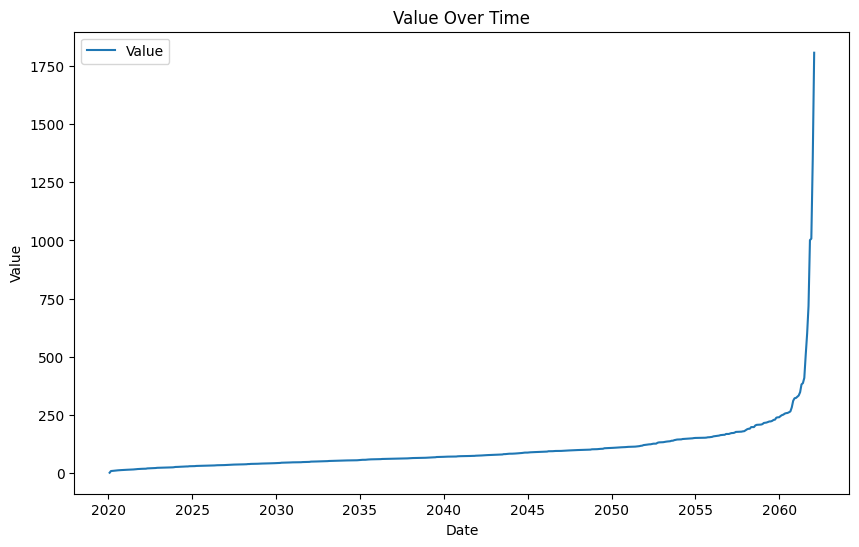


ARIMA Model
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  404
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -288.537
Date:                Sun, 22 Dec 2024   AIC                            589.074
Time:                        23:09:16   BIC                            613.068
Sample:                             0   HQIC                           598.573
                                - 404                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1210      0.024      5.030      0.000       0.074       0.168
ar.L2          0.1432      0.017      8.202      0.000       0.109       0.177
ar.L3          0.2013      0.023      8

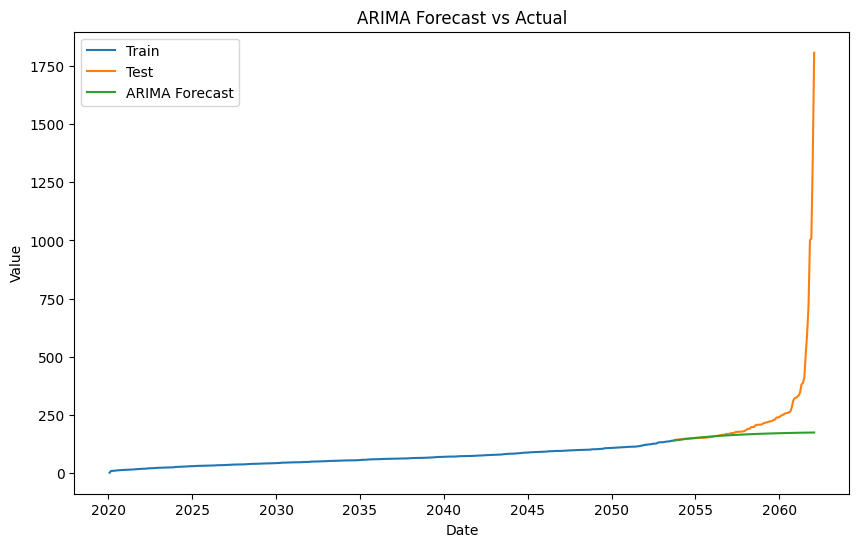


Prophet Model


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb7bln5rw/2yu6rwig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb7bln5rw/7oy8g91k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75475', 'data', 'file=/tmp/tmpb7bln5rw/2yu6rwig.json', 'init=/tmp/tmpb7bln5rw/7oy8g91k.json', 'output', 'file=/tmp/tmpb7bln5rw/prophet_modell3k_bwb_/prophet_model-20241222230918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:09:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:09:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

Prophet RMSE: 251.4614094767456


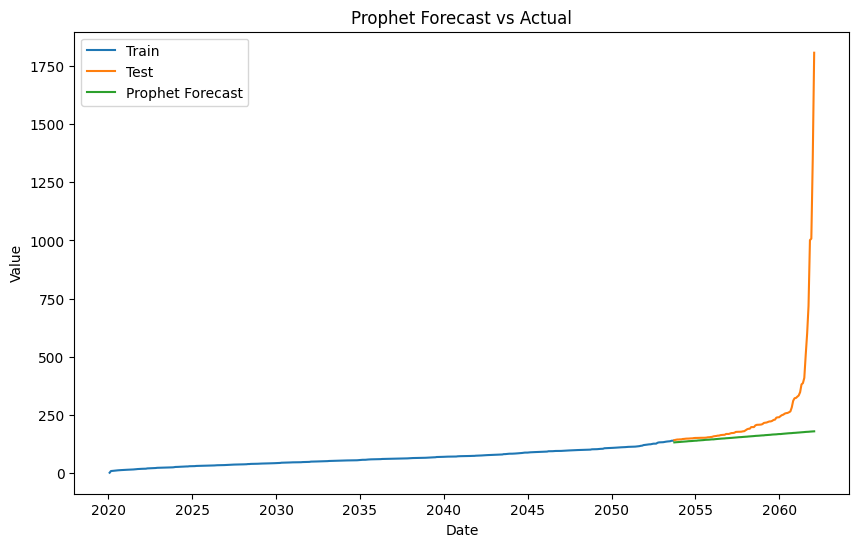

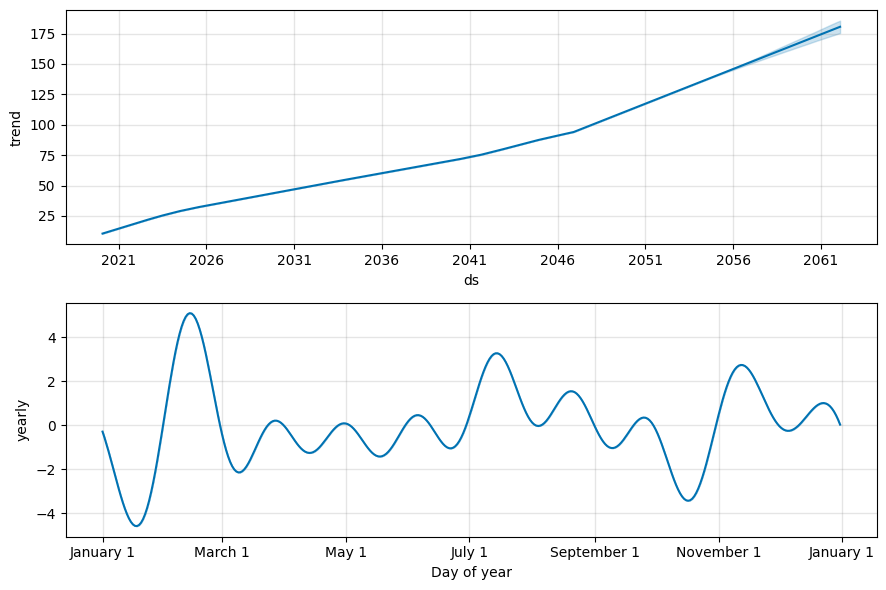

In [9]:

# Keep only numeric columns and Symbol for aggregation
numeric_columns = df.select_dtypes(include=[np.number]).columns
df = df[["Symbol"] + list(numeric_columns)]

# Aggregate by Symbol and select the "Price" column
df = df.groupby("Symbol").mean().reset_index()
df = df[["Symbol", "Price"]]

# Sort for synthetic time ordering
df = df.sort_values(by="Price").reset_index(drop=True)
df["date"] = pd.date_range(start="2020-01-01", periods=len(df), freq="M")

# Select relevant columns for time series analysis
df = df[["date", "Price"]].rename(columns={"Price": "value"})

# Plot the value data
plt.figure(figsize=(10, 6))
plt.plot(df["date"], df["value"], label="Value")
plt.title("Value Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

# Split into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# ARIMA Model
print("\nARIMA Model")
arima_model = ARIMA(train["value"], order=(5, 1, 0))
arima_fit = arima_model.fit()
print(arima_fit.summary())

# Make predictions
arima_forecast = arima_fit.forecast(steps=len(test))
rmse_arima = sqrt(mean_squared_error(test["value"], arima_forecast))
print(f"ARIMA RMSE: {rmse_arima}")

# Plot ARIMA predictions
plt.figure(figsize=(10, 6))
plt.plot(train["date"], train["value"], label="Train")
plt.plot(test["date"], test["value"], label="Test")
plt.plot(test["date"], arima_forecast, label="ARIMA Forecast")
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

# Prophet Model
print("\nProphet Model")
prophet_data = df.rename(columns={"date": "ds", "value": "y"})
prophet_train = prophet_data[:train_size]
prophet_test = prophet_data[train_size:]

# Train Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Make predictions
future = prophet_model.make_future_dataframe(periods=len(test), freq="M")
forecast = prophet_model.predict(future)

# Extract predicted values for test range
prophet_forecast = forecast.loc[forecast["ds"].isin(prophet_test["ds"]), "yhat"].values
rmse_prophet = sqrt(mean_squared_error(test["value"], prophet_forecast))
print(f"Prophet RMSE: {rmse_prophet}")

# Plot Prophet predictions
plt.figure(figsize=(10, 6))
plt.plot(train["date"], train["value"], label="Train")
plt.plot(test["date"], test["value"], label="Test")
plt.plot(test["date"], prophet_forecast, label="Prophet Forecast")
plt.title("Prophet Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

# Prophet Forecast Components
prophet_model.plot_components(forecast)
plt.show()
